# **Pneumonia Detection**


#### **Import necessary packages**

In [0]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
%matplotlib inline

import os

#### **Path to the project**

In [0]:
PATH = "/content/drive/My Drive/AIML/project"

In [0]:
print(os.listdir(PATH))

['stage_2_detailed_class_info.csv', 'stage_2_test_images.zip', 'stage_2_train_images.zip', 'stage_2_train_labels.csv', 'test', 'train']


#### **Load Data**

In [0]:
train_labels_df = pd.read_csv(PATH+'/stage_2_train_labels.csv')
class_info_df = pd.read_csv(PATH+'/stage_2_detailed_class_info.csv')

In [0]:
print("train lables shape:", train_labels_df.shape)
print("class info shape:", class_info_df.shape)

train lables shape: (30227, 6)
class info shape: (30227, 2)


In [0]:
train_labels_df.sample(5)

patientId      x      y  width  height  \
20040  b89e287f-5a3a-4f27-baf9-38759fed98cb    NaN    NaN    NaN     NaN   
24802  dec5c8de-c916-441c-a23d-16b8815658d1    NaN    NaN    NaN     NaN   
7315   56067473-2508-4ffa-be6a-7f70f3ea17cf    NaN    NaN    NaN     NaN   
14627  9038b827-4244-4154-bcf3-2d14c486bf54  620.0  249.0  289.0   595.0   
18976  b17e8b6f-5d4a-4224-8017-ffb02a1cbabd    NaN    NaN    NaN     NaN   

       Target  
20040       0  
24802       0  
7315        0  
14627       1  
18976       0

In [0]:
class_info_df.sample(5)

patientId                         class
15544  97be853a-7fc0-43cd-85c3-a92ad92e5350                  Lung Opacity
28381  fb4406f0-2d2c-4571-9b15-5db51e7cbe60  No Lung Opacity / Not Normal
20560  bc03198b-57f4-47b5-8808-114fd5cb9808                  Lung Opacity
29085  037e120a-24fa-4f9c-8813-111136e3c288                        Normal
5178   44cb1e82-07aa-491a-b55a-ec03773ecad4                        Normal

In 'class detailed info dataset' are given the detailed information about the type of positive or negative class associated with a certain patient.

In 'train labels' dataset are given the patient ID and the window (x min, y min, width and height of the) containing evidence of pneumonia.

From the data its been observed that the data contain lots of missing data (NaN)

#### **Data Exploration**

##### Identify the missing data


In [0]:
def count_missing_data(data_df):
    total = data_df.isnull().sum().sort_values(ascending = False)
    percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [0]:
count_missing_data(train_labels_df)

Total    Percent
height     20672  68.389188
width      20672  68.389188
y          20672  68.389188
x          20672  68.389188
Target         0   0.000000
patientId      0   0.000000

In [0]:
count_missing_data(class_info_df)

Total  Percent
class          0      0.0
patientId      0      0.0

The percent missing for x,y, height and width in train labels represents the percent of the target 0 (not Lung opacity/Normal).

##### Check the class distribution from the class details

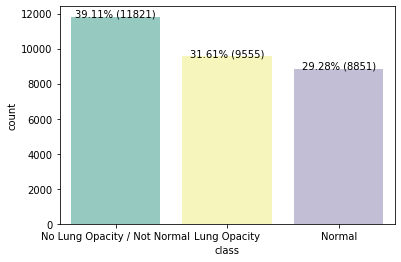

In [0]:
f, ax = plt.subplots(1,1, figsize=(6,4))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')

total = float(len(class_info_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}% ({:d})'.format(100*height/total, height),
            ha="center") 
plt.show()

No Lung Opacity / Not Normal (39.11%)and Normal(29.28) have together the same percent (68.39%) as the percent of missing values for target window in class details information.

In the train set, the percent of data with value for Target = 1 is therefore 31.61%.

In [0]:
### Merge train and class info details 

In [0]:
# Let's merge now the two datasets, using Patient ID as the merge criteria.
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')
train_class_df.sample(5)

patientId      x      y  width  height  \
17618  8c40fc60-e753-420e-8a47-1e9c1990a924    NaN    NaN    NaN     NaN   
2932   2a15b6f2-2a17-454d-b14c-ba1bb4bd79f4  242.0  610.0  142.0   218.0   
9328   5399e1e3-a2a1-48c3-80ab-29b18ecb98f4    NaN    NaN    NaN     NaN   
20317  9eb9f945-1832-4e10-b902-719d11855f47    NaN    NaN    NaN     NaN   
19926  9bb53972-9fe8-40ff-b241-1603ba269df6    NaN    NaN    NaN     NaN   

       Target         class  
17618       0        Normal  
2932        1  Lung Opacity  
9328        0        Normal  
20317       0        Normal  
19926       0        Normal

In [0]:
### Density of target values vs classes

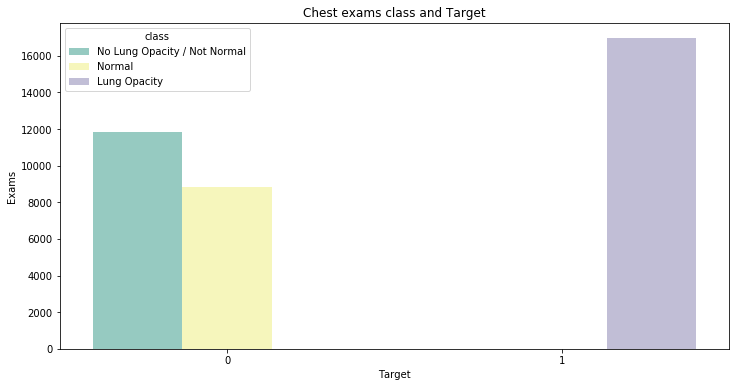

In [0]:
# Let's plot the number of examinations for each class detected, grouped by Target value.
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()

All chest examinations withTarget = 1 (pathology detected) associated with class: Lung Opacity.

The chest examinations with Target = 0 (no pathology detected) are either of class: Normal or class: No Lung Opacity / Not Normal.

In [0]:
### Analyze the lung opacity window

<Figure size 432x288 with 0 Axes>

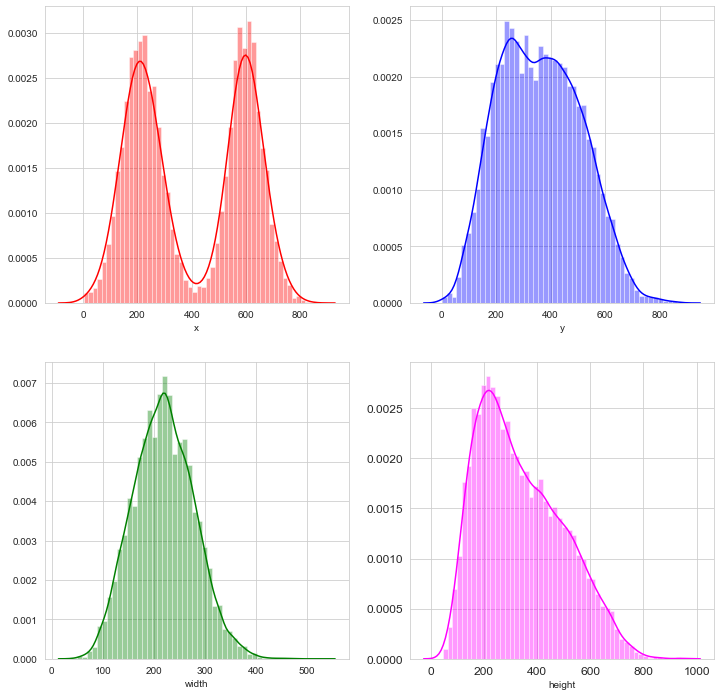

In [0]:
# For the class Lung Opacity, corresponding to values of Target = 1, we plot the density of x, y, width and height.
target1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

We can plot also the center of the rectangles points in the plane x0y. The centers of the rectangles are the points
 xc=x+width/2
    and
 yc=y+height/2
 
 
We will show a sample of center points superposed with the corresponding sample of the rectangles.

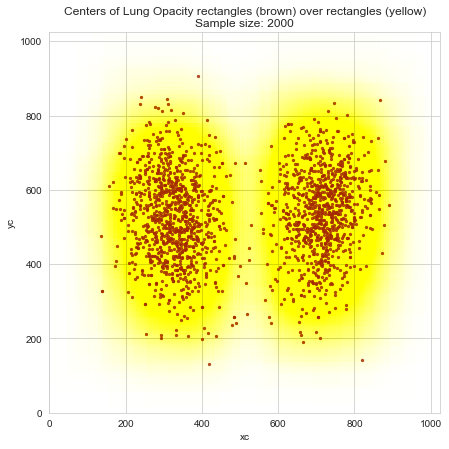

In [0]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

#### **Explore DICOM data**

In [0]:
# Read a sample of DICOM data
image_sample_path = os.listdir(PATH+'/train/stage_2_train_images')[:5]
print(image_sample_path)

['0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', '000924cf-0f8d-42bd-9158-1af53881a557.dcm', '000db696-cf54-4385-b10b-6b16fbb3f985.dcm', '000fe35a-2649-43d4-b027-e67796d412e0.dcm', '001031d9-f904-4a23-b3e5-2c088acd19c6.dcm']


In [0]:
# Read the 'train' and 'test' image data
image_train_path = os.listdir(PATH+'/train/stage_2_train_images')
image_test_path = os.listdir(PATH+'/test/stage_2_test_images')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26684 
Number of images in test set: 2305


In [0]:
# check for duplicate reconrds in training set
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique()) 

Unique patientId in  train_class_df:  26684


In [0]:
train_class_df.shape

(37629, 7)

**But the total number of records are 37629. So we have to find out which all records are duplicates**

In [0]:
tmp = train_class_df.groupby(['patientId','Target', 'class'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target','class']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Exams', 'Target','Class', 'Entries']
df2

Exams  Target                         Class  Entries
0      1       0  No Lung Opacity / Not Normal    11821
1      1       0                        Normal     8851
2      1       1                  Lung Opacity     2614
3      4       1                  Lung Opacity     3266
4      9       1                  Lung Opacity      119
5     16       1                  Lung Opacity       13

#### **Extract one image and process the DICOM information.**

In [0]:
samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join(PATH,"train/stage_2_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

Let's sample few images having the Target = 1.

**Plot DICOM images with Target = 1**

In [0]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"train/stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

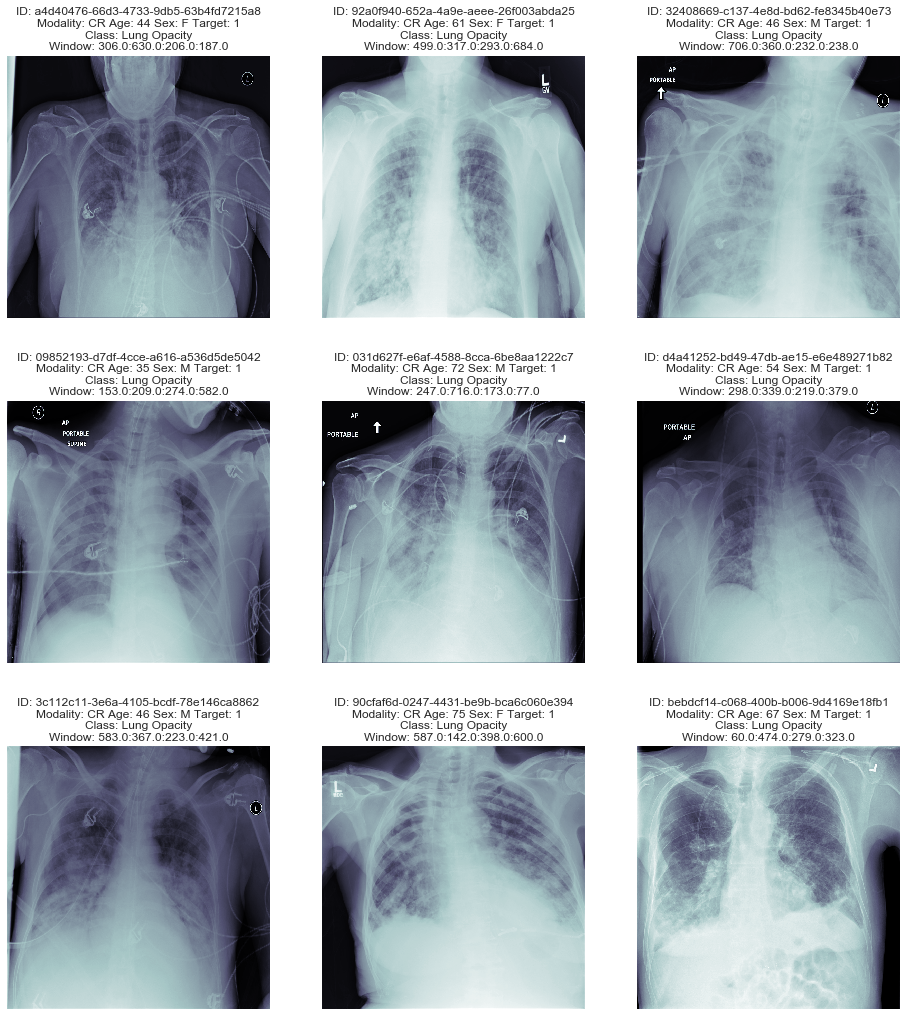

In [0]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

#### **Plot DICOM images with Target = 1, with bounding boxes**

In [0]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"train/stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="blue",alpha = 0.1))   
    plt.show()

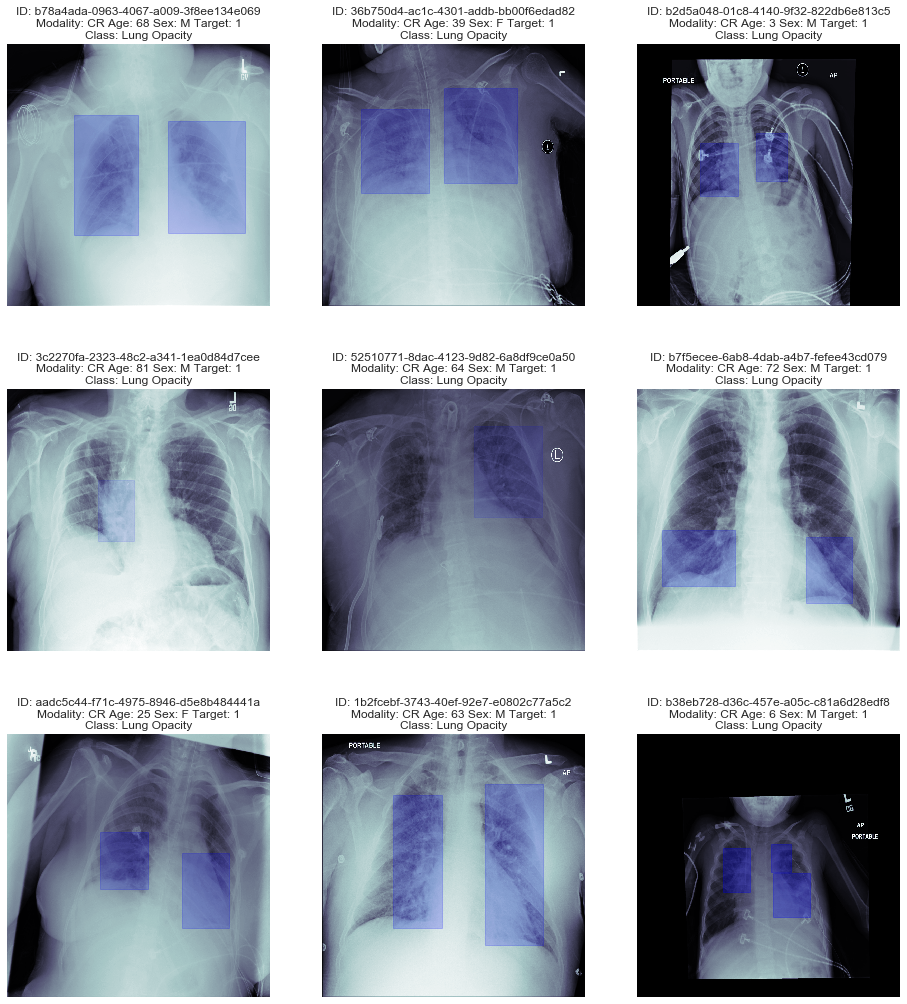

In [0]:
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))

#### **Plot DICOM images with Target = 0**

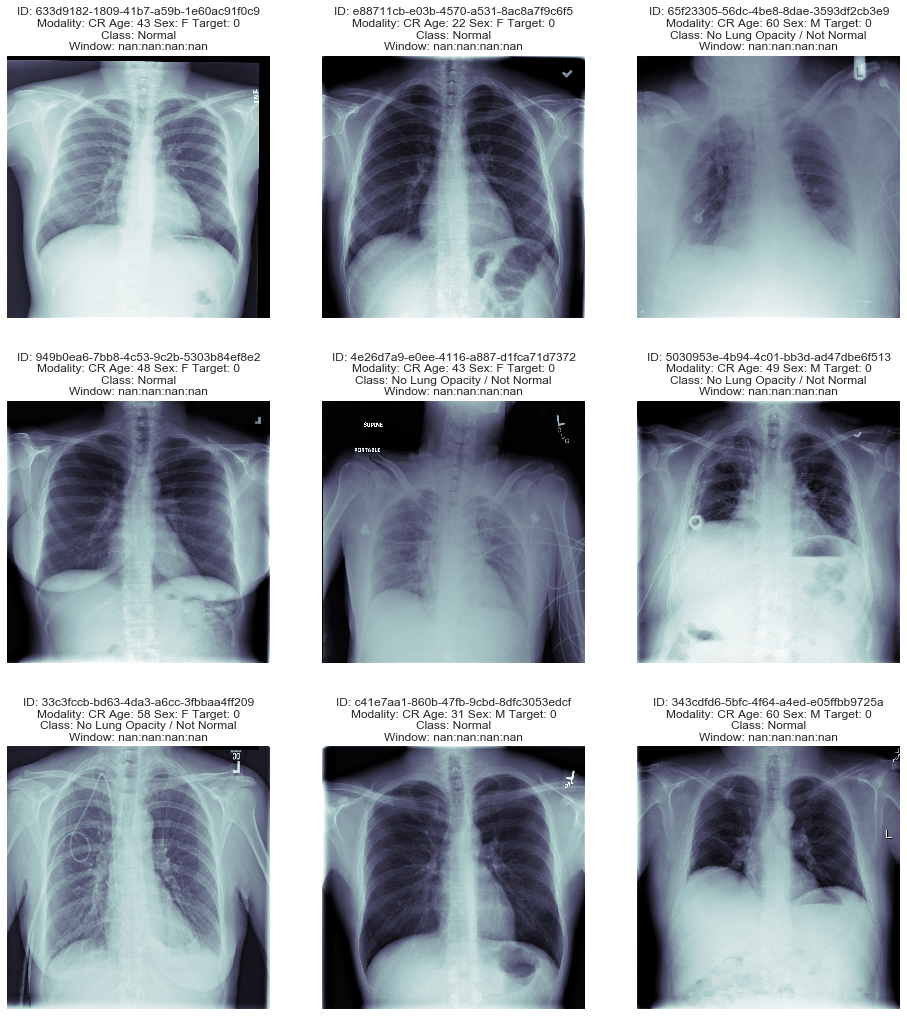

In [0]:
show_dicom_images(train_class_df[train_class_df['Target']==0].sample(9))

#### **Build the model**

In [0]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join(PATH+'/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]


In [0]:
# load and shuffle filenames
folder = PATH+'/train/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))


n train samples 24124
n valid samples 2560
Total train images: 26684
Images with pneumonia: 6012


In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia

        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        msk = resize(msk, (self.image_size, self.image_size), mode='symmetric') > 0.5
        
        

        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    # Added start
    #x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    #x = keras.layers.MaxPool2D(2)(x)
    # Added End
    return x


def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)

    #Added Start
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    #Added End
    
    addInput = x;
    print("Add input shape:", addInput.shape)
    print("Resnet block input shape:", inputs.shape)
    resBlockOut = keras.layers.add([addInput, inputs])
    print("Resnet block out shape:", resBlockOut.shape)
    out = keras.layers.concatenate([resBlockOut, addInput], axis=3)
    print("concat block out shape:", out.shape)
    out = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(out)
    print("mixed block out shape:", out.shape)
    return out

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



#### **IoU Loss function**

In [0]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))




#### **Model Compile and Fit**

In [0]:
# create network and compiler
model = create_network(input_size=128, channels=16, n_blocks=2, depth=3)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])
print("model summary:", model.summary())
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Add input shape: (?, 64, 64, 32)
Resnet block input shape: (?, 64, 64, 32)
Resnet block out shape: (?, 64, 64, 32)
concat block out shape: (?, 64, 64, 64)
mixed block out shape: (?, 64, 64, 32)
Add input shape: (?, 64, 64, 32)
Resnet block input shape: (?, 64, 64, 32)
Resnet block out shape: (?, 64, 64, 32)
concat block out shape: (?, 64, 64, 64)
mixed block out shape: (?, 64, 64, 32)
Add input shape: (?, 32, 32, 64)
Resnet block input shape: (?, 32, 32, 64)
Resnet block out shape: (?, 32, 32, 64)
concat block out shape: (?, 32, 32, 128)
mixed block out shape: (?, 32, 32, 64)
Add input shape: (?, 32, 32, 64)
Resnet block input shape: (?, 32, 32, 64)
Resnet block out shape: (?, 32, 32, 64)
concat block out shape: (?, 32, 32, 128)
mixed block out shape: (?, 32, 32, 64)
Add input shape: (?, 16, 16, 128)
Resnet block input shape: (?, 16, 16, 128)
Resnet block out shape: (?,

batch_normalization_7 (BatchNor (None, 64, 64, 32)   128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 64, 64, 32)   0           batch_normalization_7[0][0]      
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 64, 64, 64)   2048        leaky_re_lu_7[0][0]              
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 32, 32, 64)   256         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
leaky_re_l

leaky_re_lu_17 (LeakyReLU)      (None, 16, 16, 128)  0           batch_normalization_17[0][0]     
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 16, 16, 128)  147456      leaky_re_lu_17[0][0]             
__________________________________________________________________________________________________
add_4 (Add)                     (None, 16, 16, 128)  0           conv2d_22[0][0]                  
                                                                 max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 16, 16, 256)  0           add_4[0][0]                      
                                                                 conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 

In [0]:
# create train and validation generators
folder = PATH+'/train/stage_2_train_images'
#train_gen = generator(folder, train_filenames[0:1000], pneumonia_locations, batch_size=16, image_size=128, shuffle=False, augment=True, predict=False)
#valid_gen = generator(folder, valid_filenames[1000:1200], pneumonia_locations, batch_size=16, image_size=128, shuffle=False, predict=False)

train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=False, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=10, shuffle=True, verbose=2)

#history = model.fit_generator(train_gen, callbacks=[learning_rate], epochs=25, workers=4, use_multiprocessing=True)


Epoch 1/10
1507/1507 - 6944s - loss: 0.4647 - acc: 0.9641 - mean_iou: 0.6393 - val_loss: 0.5602 - val_acc: 0.9048 - val_mean_iou: 0.3735
Epoch 2/10
1507/1507 - 6775s - loss: 0.4487 - acc: 0.9668 - mean_iou: 0.6724 - val_loss: 0.4528 - val_acc: 0.9569 - val_mean_iou: 0.6387
Epoch 3/10
1507/1507 - 6768s - loss: 0.4408 - acc: 0.9671 - mean_iou: 0.6795 - val_loss: 0.4773 - val_acc: 0.9751 - val_mean_iou: 0.7501
Epoch 4/10
1507/1507 - 6779s - loss: 0.4346 - acc: 0.9684 - mean_iou: 0.6884 - val_loss: 0.4778 - val_acc: 0.9508 - val_mean_iou: 0.5782
Epoch 5/10
1507/1507 - 6789s - loss: 0.4302 - acc: 0.9688 - mean_iou: 0.6916 - val_loss: 0.4356 - val_acc: 0.9599 - val_mean_iou: 0.6458
Epoch 6/10
1507/1507 - 6787s - loss: 0.4270 - acc: 0.9691 - mean_iou: 0.6955 - val_loss: 0.4227 - val_acc: 0.9677 - val_mean_iou: 0.6967
Epoch 7/10
1507/1507 - 6792s - loss: 0.4237 - acc: 0.9694 - mean_iou: 0.6959 - val_loss: 0.4543 - val_acc: 0.9731 - val_mean_iou: 0.7298
Epoch 8/10
1507/1507 - 6794s - loss: 0.42

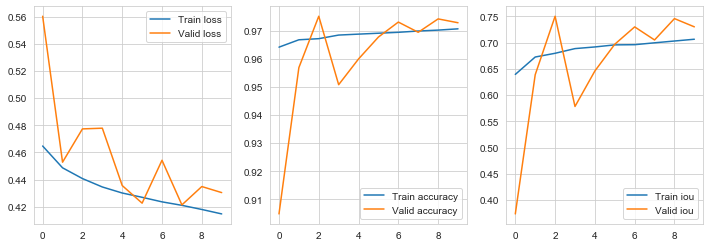

In [0]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [0]:
model.save(r'C:\Users\Ram Mohan\Google Drive\rsna_data\Mixed_link_model.h5')

In [0]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=15, shuffle=True, verbose=2)

Epoch 1/15
1507/1507 - 7013s - loss: 0.4179 - acc: 0.9704 - mean_iou: 0.7030 - val_loss: 0.4549 - val_acc: 0.9738 - val_mean_iou: 0.7202
Epoch 2/15
1507/1507 - 6879s - loss: 0.4159 - acc: 0.9704 - mean_iou: 0.7031 - val_loss: 0.4292 - val_acc: 0.9717 - val_mean_iou: 0.7022
Epoch 3/15
1507/1507 - 6952s - loss: 0.4135 - acc: 0.9705 - mean_iou: 0.7039 - val_loss: 0.4172 - val_acc: 0.9697 - val_mean_iou: 0.6906
Epoch 4/15
1507/1507 - 6805s - loss: 0.4122 - acc: 0.9707 - mean_iou: 0.7039 - val_loss: 0.4247 - val_acc: 0.9660 - val_mean_iou: 0.6843
Epoch 5/15
1507/1507 - 6818s - loss: 0.4097 - acc: 0.9708 - mean_iou: 0.7072 - val_loss: 0.4227 - val_acc: 0.9657 - val_mean_iou: 0.6956
Epoch 6/15
1507/1507 - 6814s - loss: 0.4078 - acc: 0.9713 - mean_iou: 0.7147 - val_loss: 0.4112 - val_acc: 0.9711 - val_mean_iou: 0.7256
Epoch 7/15
1507/1507 - 6816s - loss: 0.4058 - acc: 0.9715 - mean_iou: 0.7149 - val_loss: 0.4102 - val_acc: 0.9713 - val_mean_iou: 0.7161
Epoch 8/15
1507/1507 - 6794s - loss: 0.40

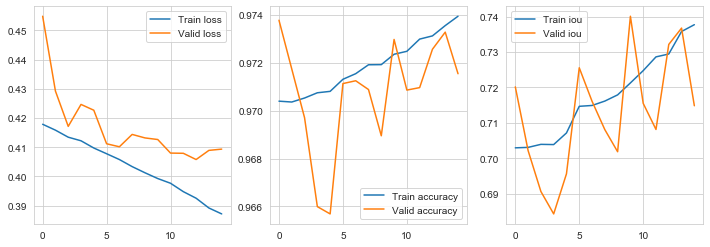

In [0]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [0]:
model.save('./Mixed_link_model-1.h5')

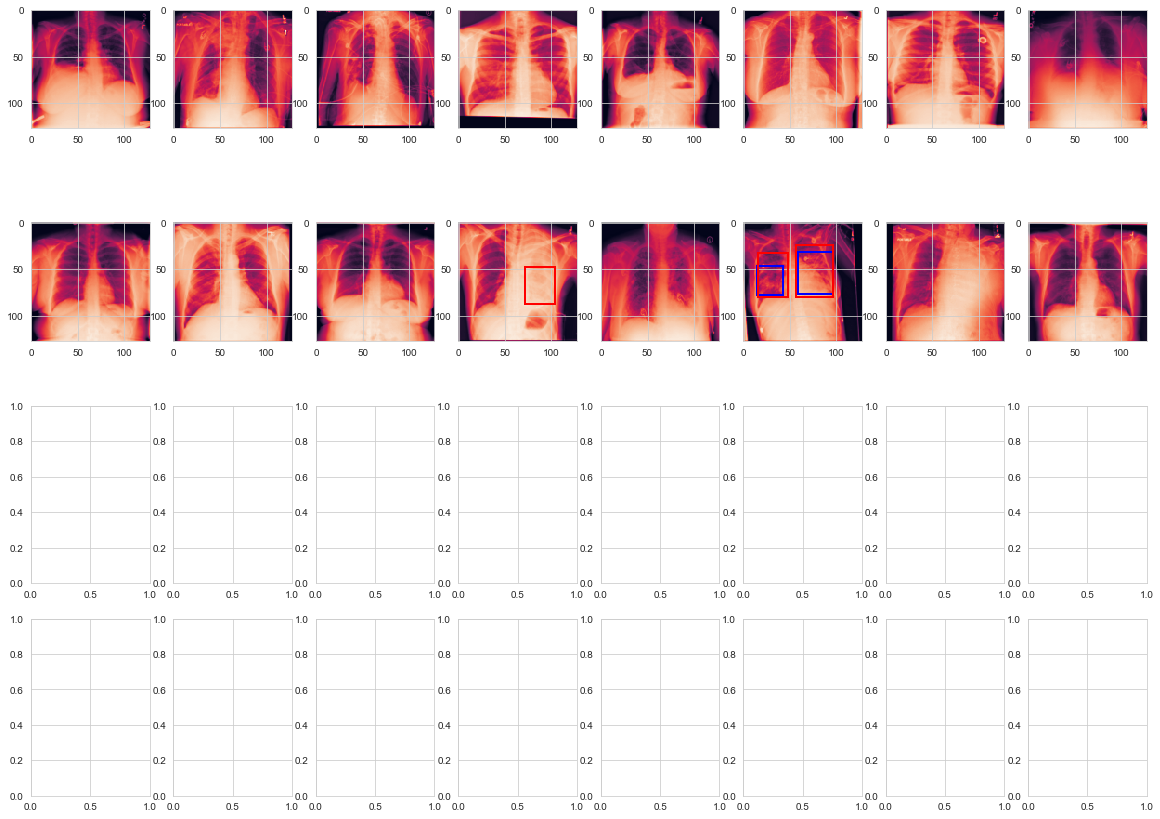

In [0]:


for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

